# Creating a LangGraph AI Team to Answer Map Questions

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1nmuw3igbeB2hZ8rbzv-Hew-Z1zf70QXM?usp=sharing)

This notebook demonstrates how to use `langgraph` to create a workflow for geographical data retrieval, route calculation, and map visualization using the TomTom API.

## Installation

First, we need to install the necessary packages:

In [1]:
!pip install -q langgraph langchain langchain_openai langchainhub folium

In [2]:
!pip freeze | grep "lang\|openai\|folium"

folium==0.14.0
google-ai-generativelanguage==0.6.4
google-cloud-language==2.13.3
langchain==0.2.1
langchain-core==0.2.2
langchain-openai==0.1.8
langchain-text-splitters==0.2.0
langchainhub==0.1.17
langcodes==3.4.0
langgraph==0.0.57
langsmith==0.1.63
language_data==1.2.0
libclang==18.1.1
openai==1.30.5


## Setup
We will set up our environment variables, including the OpenAI API key and the TomTom API key.

In [3]:
from google.colab import userdata
import os

# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# nt0WpoWFNPf7PxPWE2qcHgjtthK73CPY is default tomtom key
os.environ["TOMTOM_API_KEY"] = userdata.get("TOMTOM") or 'nt0WpoWFNPf7PxPWE2qcHgjtthK73CPY'

## Tool Definitions
We define tools for searching geographical data and calculating routes using the TomTom API.

In [4]:
import requests
from langchain.tools import tool
import json

# apis:
# https://developer.tomtom.com/search-api/api-explorer
# https://developer.tomtom.com/routing-api/api-explorer

@tool("search_geodata")
def search_geo(name, return_direct=True):
    """
    Tool to get data about a geographical object by name.
    Input: string name
    Output: dictionary of summary and points
    """
    print("search_geodata", name)

    headers = {
        'accept': '*/*',
    }

    # Italy approximate coordinates
    lat=41.8719
    lon=12.5674

    params = {
        'lat': str(lat),
        'lon': str(lon),
        'minFuzzyLevel': '1',
        'maxFuzzyLevel': '2',
        'view': 'Unified',
        'relatedPois': 'off',
        'key': os.environ["TOMTOM_API_KEY"],
    }

    response = requests.get(f'https://api.tomtom.com/search/2/search/{name}.json', params=params, headers=headers)
    if response.status_code == 200:
        return response.json()
    return {}

@tool("calculate_route")
def calculate_route(coords):
    """
    Tool to calculate route from coordinates passed
    Input: list of list or tuple coordinates:
    `[[lat, lon], [lat, lon]] or [(lat, lon), (lat, lon)]`
    """
    print("calculate_route", coords)

    headers = {
        'accept': '*/*',
    }

    params = {
        'key': os.environ["TOMTOM_API_KEY"],
    }

    coords_str = "%3A".join([f"{x[0]}%2C{x[1]}" for x in coords])
    response = requests.get(
        f'https://api.tomtom.com/routing/1/calculateRoute/{coords_str}/json',
        params=params,
        headers=headers,
    )
    if response.status_code == 200:
    # The only reason we're saving the coordinates instead of passing is to save tokens and fit the limit
        try:
            with open('data.json', 'w', encoding='utf-8') as f:
                legs = response.json()['routes'][0]['legs']
                points = [point for leg in legs for point in leg['points']]
                json.dump(points, f, ensure_ascii=False, indent=4)
                return response.json()['summary']
        except Exception as e:
            print(e)
    else:
        print(response.status_code, response.text)
    return {}

In [5]:
import folium

@tool
def draw_route(return_direct=True):
    """
    Draws a map based on coordinates
    """
    with open("data.json", "r") as file:
        points = json.load(file)
    print("draw_route", points)
    m = folium.Map()

    folium.Marker((points[0]['latitude'], points[0]['longitude']),
                  icon=folium.Icon(
                      color='green', icon='crosshairs', prefix='fa')
                ).add_to(m)
    folium.Marker((points[-1]['latitude'], points[-1]['longitude']),
                  icon=folium.Icon(color='red', icon='crosshairs', prefix='fa')
                ).add_to(m)

    route_xy = [(c['latitude'], c['longitude']) for c in points]

    folium.PolyLine(route_xy, smooth_factor=1).add_to(m)
    m.save('map.html')
    return m

In [6]:
# check response from a tool
search_geo("Colosseum")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


search_geodata Colosseum


{'summary': {'query': 'colosseum',
  'queryType': 'NON_NEAR',
  'queryTime': 85,
  'numResults': 10,
  'offset': 0,
  'totalResults': 100,
  'fuzzyLevel': 1,
  'geoBias': {'lat': 41.8719, 'lon': 12.5674},
  'queryIntent': []},
 'results': [{'type': 'POI',
   'id': 'hde-Le5AB1BCwBpr5IEraA',
   'score': 0.9996293783,
   'dist': 6452.040166,
   'info': 'search:ta:380009009004280-IT',
   'poi': {'name': 'The Colosseum',
    'phone': '+39 06 3996 7700',
    'categorySet': [{'id': 7376002}],
    'url': 'www.il-colosseo.it',
    'categories': ['building', 'important tourist attraction'],
    'classifications': [{'code': 'IMPORTANT_TOURIST_ATTRACTION',
      'names': [{'nameLocale': 'en-US',
        'name': 'important tourist attraction'},
       {'nameLocale': 'en-US', 'name': 'building'}]}]},
   'address': {'streetName': 'Piazza del Colosseo',
    'municipality': 'Rome',
    'neighbourhood': 'Rione Celio',
    'countrySecondarySubdivision': 'Rome',
    'countrySubdivision': 'Lazio',
    'cou

## Creating Agents
We create agents using `langchain` and define a workflow using `langgraph`.

### Agent Creation
We define a function to create agents.

In [7]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


def create_agent(llm: ChatOpenAI, tools: list, system_message: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_message,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Defining Agents
We define three agents: Searcher, RouteGenerator, and MapVisualizator.

In [8]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [9]:
import functools

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True)

# Create the research agent
search_agent = create_agent(
    llm,
    tools=[search_geo],
    system_message="You should provide accurate data regarding a geographical place",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Searcher")

# Create the visualization generator agent
route_agent = create_agent(
    llm,
    [calculate_route],
    system_message="""You should provide a list of coordinates forming a route.
    Aggregate the coordinates of all stops and call the calculate_route once
    per each route""",
)
route_node = functools.partial(agent_node, agent=route_agent, name="RouteGenerator")

# Create the report generator agent
map_agent = create_agent(
    llm,
    [draw_route],
    system_message="Your job is to visualize the map based on the coordinates list",
)
map_node = functools.partial(agent_node, agent=map_agent, name="MapVisualizator")

## Creating the Workflow
We define the workflow using langgraph.

### Supervisor Chain
We create a supervisor chain to manage the workflow.

In [10]:
# Define the team members
members = ["Searcher", "RouteGenerator", "MapVisualizator"]

# Define the options for the next action
options = ["FINISH"] + members

# Define the system prompt
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the "
    "following workers: {members}. Given the following user request, "
    "respond with the worker to act next. Each worker will perform a "
    "task and respond with their results and status. Pay attention to the "
    "format requested in the tool description."
    "Use the collected data to plot the map."
    "When finished, respond with FINISH."
)

# Create the prompt template
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

# Define the function for routing the next action
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}



### Workflow Definition
We define the workflow using `StateGraph`.

In [11]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

# Define the AgentState class to represent the state of each agent
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

# Create the supervisor chain using the ChatPromptTemplate and other configurations
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

# Define the workflow using the StateGraph
workflow = StateGraph(AgentState)
workflow.add_node("Searcher", search_node)
workflow.add_node("RouteGenerator", route_node)
workflow.add_node("MapVisualizator", map_node)
workflow.add_node("supervisor", supervisor_chain)

In [12]:
# Ensure workers report back to the supervisor when done
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {member: member for member in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda state: state["next"], conditional_map)
workflow.set_entry_point("supervisor")

# Compile the workflow graph
graph = workflow.compile()

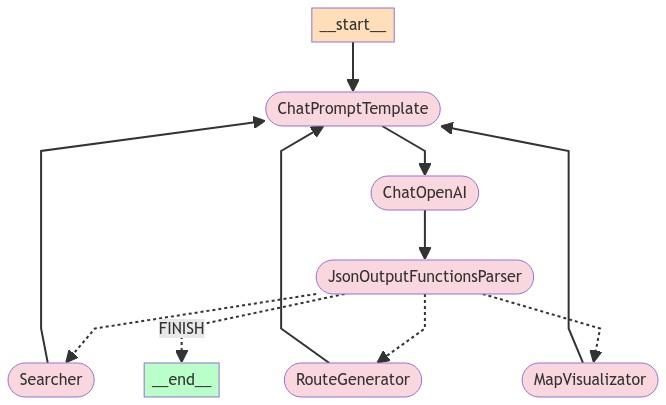

In [13]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Running the Workflow
We run the workflow with a sample query.

In [14]:
# Uffizi is misspelled on purpose
query = """Draw a map from colosseum to ufizzi gallery and to the leaning tower afterwards"""

In [15]:
for s in graph.stream(
    {"messages": [HumanMessage(content=query)]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Searcher'}}
----
search_geodata Colosseum
search_geodata Uffizi Gallery
search_geodata Leaning Tower of Pisa
{'Searcher': {'messages': [HumanMessage(content='Here are the details for the locations you requested:\n\n### The Colosseum\n- **Name:** The Colosseum\n- **Address:** Piazza del Colosseo, 00184 Rome, Italy\n- **Coordinates:** 41.889957, 12.493336\n- **Phone:** +39 06 3996 7700\n- **Website:** [www.il-colosseo.it](http://www.il-colosseo.it)\n\n### Uffizi Gallery\n- **Name:** Uffizi Gallery\n- **Address:** Piazzale degli Uffizi, 6, 50122 Firenze FI, Italy\n- **Coordinates:** 43.768732, 11.255611\n- **Phone:** +39 055 238 8651\n- **Website:** [www.uffizi.it](https://www.uffizi.it)\n\n### Leaning Tower of Pisa\n- **Name:** Torre di Pisa (Leaning Tower of Pisa)\n- **Address:** Piazza del Duomo, 56126 Pisa, Italy\n- **Coordinates:** 43.723023, 10.396502\n- **Phone:** +39 050 835011\n- **Website:** [www.opapisa.it](http://www.opapisa.it/it/la-piazza-dei-miracol

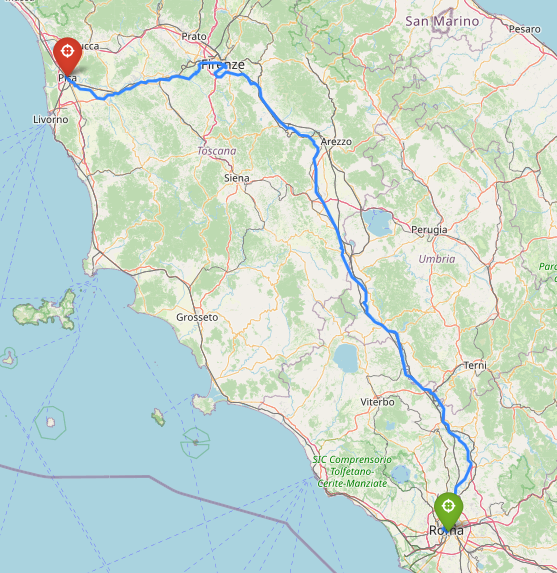